In [52]:
# for data handling
import pandas as pd
import numpy as np

# train-test split
from sklearn.model_selection import train_test_split

# loss functions for today
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# stuff for evaluating classifiers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # for displaying a pretty confusion matrix

# dummy models for comparison
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# visual models
import seaborn as sns
import matplotlib.pyplot as plt

Due to an error in the dataset the airport identifiers from the entirety of October are compromised of intergers instead of the airport ID. This is quite troublesome to fix which is why we've decided to remove the rows from October even though this will defininetly decrease the accuracy of our model.

In [53]:
flight_df = pd.read_csv('flights.csv', dtype={'DESTINATION_AIRPORT': str, 'ORIGIN_AIRPORT': str}, nrows=50000)

# Exploratory

In [41]:
flight_df.shape

(50000, 31)

In [42]:
flight_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 50000 non-null  int64  
 1   MONTH                50000 non-null  int64  
 2   DAY                  50000 non-null  int64  
 3   DAY_OF_WEEK          50000 non-null  int64  
 4   AIRLINE              50000 non-null  object 
 5   FLIGHT_NUMBER        50000 non-null  int64  
 6   TAIL_NUMBER          49941 non-null  object 
 7   ORIGIN_AIRPORT       50000 non-null  object 
 8   DESTINATION_AIRPORT  50000 non-null  object 
 9   SCHEDULED_DEPARTURE  50000 non-null  int64  
 10  DEPARTURE_TIME       48896 non-null  float64
 11  DEPARTURE_DELAY      48896 non-null  float64
 12  TAXI_OUT             48873 non-null  float64
 13  WHEELS_OFF           48873 non-null  float64
 14  SCHEDULED_TIME       50000 non-null  int64  
 15  ELAPSED_TIME         48753 non-null 

In [27]:
flight_df['ARRIVAL_DELAY'].max()

1384.0

Potential outlier - remove?

# Preprocessing

According to the FAA a flight is considered delayed it is delayed by 15 minutes or more.

In [58]:
df_fd = flight_df.copy()
df_fd = df_fd[df_fd.ARRIVAL_DELAY > 15]

We'll clear out some irrelevant columns and retain those we need for our prediction analysis.

In [59]:
# We will not consider cancelled or diverted flights as we are only concerned with delays
#df_fd = df_fd[df_fd.CANCELLED != 1]
#df_fd = df_fd[df_fd.DIVERTED != 1]

# Drop all columns that do not add interpretability to the model
df_fd = df_fd.drop(['YEAR', 'DEPARTURE_DELAY', 'DEPARTURE_TIME', 'TAXI_OUT','WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME',
                  'WHEELS_ON','TAXI_IN','ARRIVAL_TIME','DIVERTED','CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
                   'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1)

# Drop TAIL_NUMBER for now due to value error
df_fd = df_fd.drop(['TAIL_NUMBER', 'FLIGHT_NUMBER', 'DISTANCE'], axis=1)
    
# Fill NaNs - just to make sure
#df_fd = df_fd.fillna(0)

df_fd.head(30)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
27,1,1,4,NK,MSP,FLL,115,207,542,25.0
30,1,1,4,NK,PHX,ORD,125,204,549,43.0
50,1,1,4,B6,BQN,MCO,307,173,500,20.0
52,1,1,4,B6,SJU,MCO,400,185,605,85.0
55,1,1,4,B6,SJU,BDL,438,241,739,89.0
70,1,1,4,AA,DFW,MIA,515,161,856,102.0
73,1,1,4,US,PDX,PHX,520,150,850,60.0
74,1,1,4,AA,IAH,MIA,520,141,841,54.0
86,1,1,4,AA,DEN,DFW,530,125,835,66.0
92,1,1,4,UA,SFO,DEN,531,146,857,26.0


Encoding

In [61]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Label encoding features to change categorical variables into numerical one
df_fd['AIRLINE']= le.fit_transform(df_fd['AIRLINE'])
df_fd['ORIGIN_AIRPORT'] = le.fit_transform(df_fd['ORIGIN_AIRPORT'])
df_fd['DESTINATION_AIRPORT'] = le.fit_transform(df_fd['DESTINATION_AIRPORT'])



In [62]:
df_fd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14871 entries, 27 to 49997
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                14871 non-null  int64  
 1   DAY                  14871 non-null  int64  
 2   DAY_OF_WEEK          14871 non-null  int64  
 3   AIRLINE              14871 non-null  int32  
 4   ORIGIN_AIRPORT       14871 non-null  int32  
 5   DESTINATION_AIRPORT  14871 non-null  int32  
 6   SCHEDULED_DEPARTURE  14871 non-null  int64  
 7   SCHEDULED_TIME       14871 non-null  int64  
 8   SCHEDULED_ARRIVAL    14871 non-null  int64  
 9   ARRIVAL_DELAY        14871 non-null  float64
dtypes: float64(1), int32(3), int64(6)
memory usage: 1.1 MB


In [73]:
df_fd.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
27,1,1,4,8,193,95,115,207,542,25.0
30,1,1,4,8,211,199,125,204,549,43.0
50,1,1,4,2,34,167,307,173,500,20.0
52,1,1,4,2,252,167,400,185,605,85.0
55,1,1,4,2,252,21,438,241,739,89.0


In [71]:
le.fit(flight_df['AIRLINE'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'AA': 0, 'AS': 1, 'B6': 2, 'DL': 3, 'EV': 4, 'F9': 5, 'HA': 6, 'MQ': 7, 'NK': 8, 'OO': 9, 'UA': 10, 'US': 11, 'VX': 12, 'WN': 13}


In [84]:
le.fit(flight_df['ORIGIN_AIRPORT'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#print(le_name_mapping)

le.fit(flight_df['DESTINATION_AIRPORT'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#print(le_name_mapping)

Train-Test split

In [65]:
y = df_fd['ARRIVAL_DELAY']
X = df_fd.drop('ARRIVAL_DELAY', axis=1)

#df_fd_enc[['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
#          'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']]

Box plot visual

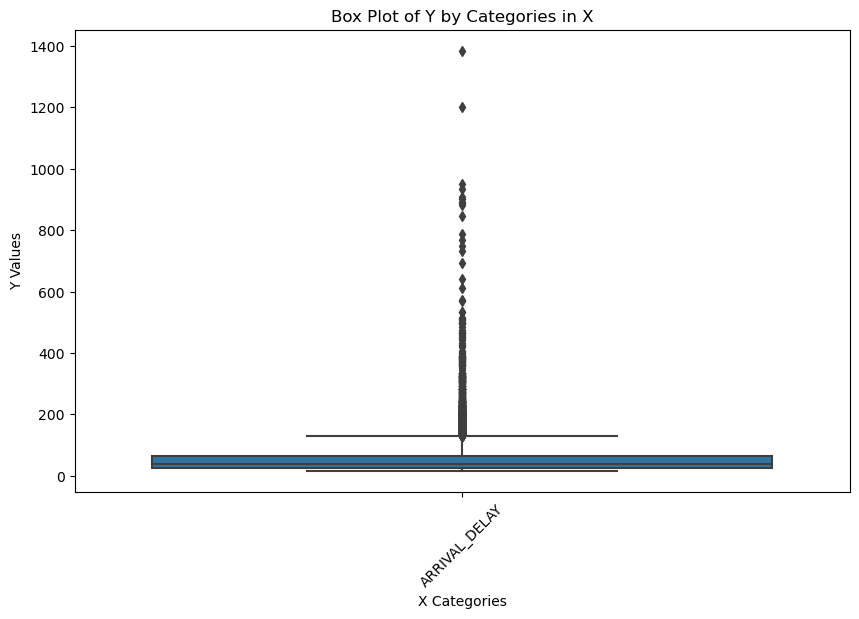

In [36]:
df_melted = pd.melt(df_fd_enc, id_vars=X, value_vars=[y])

# Create a box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', data=df_melted)
plt.title('Box Plot of Y by Categories in X')
plt.xlabel('X Categories')
plt.ylabel('Y Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

Creating training and test size

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# Regression

Code should be working, however requires a lot of memory unless we downsize the amount of rows.

In [81]:
fd_ln = LinearRegression()

fd_ln.fit(X_train, y_train)

LinearRegression()

In [82]:
print("Score: {:.3f}".format(fd_ln.score(X, y)))

Score: 0.015
